# 1. Libraries <a class='anchor' id='lib'></a> [↑](#top)

In [1]:
import os
import PIL
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize as resz
from PIL import Image, ImageOps

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

unique:  [0. 1. 2. 3.]
max:  3.0


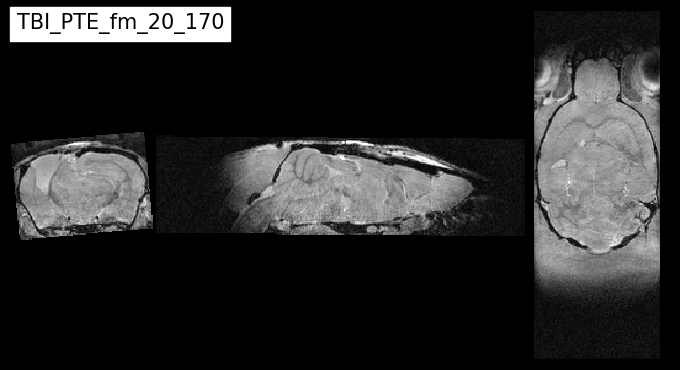

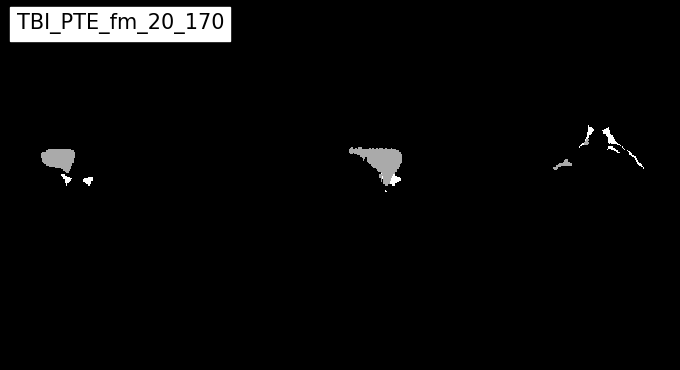

In [2]:
from utils.nifti import load_nifti
path = '../data_fix/fixed/'
case = 'TBI_PTE_fm_20_170'

# load nifti
nii_img, nii_data = load_nifti(os.path.join(path, case, 'Anat', case + '_N4.nii.gz'))

# plot nifti
nlplt.plot_anat(nii_img, title=case, display_mode='ortho', dim=-1, draw_cross=False, annotate=False, black_bg=True)

# load mask
mask_img, mask_data = load_nifti(os.path.join(path, case, 'Anat', case + '_lesion_mask.nii.gz'))

# plot nifti
nlplt.plot_anat(mask_img, title=case, display_mode='ortho', dim=-1, draw_cross=False, annotate=False, black_bg=True)

# print unique values in mask
print('unique: ', np.unique(mask_data))
print('max: ', np.max(mask_data))

unique:  [0. 1. 2. 3.]
max:  3.0


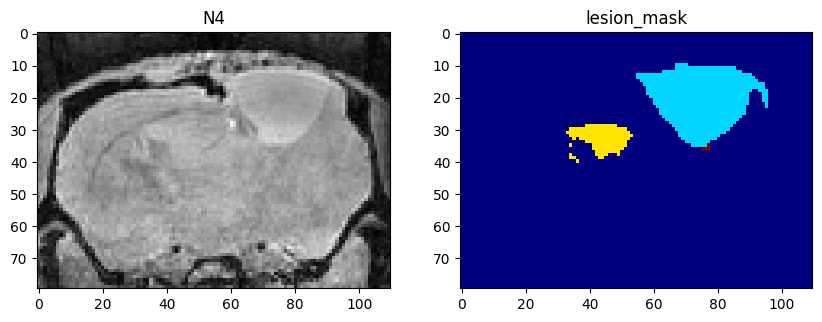

unique:  [0. 1. 2. 3.]
max:  3.0


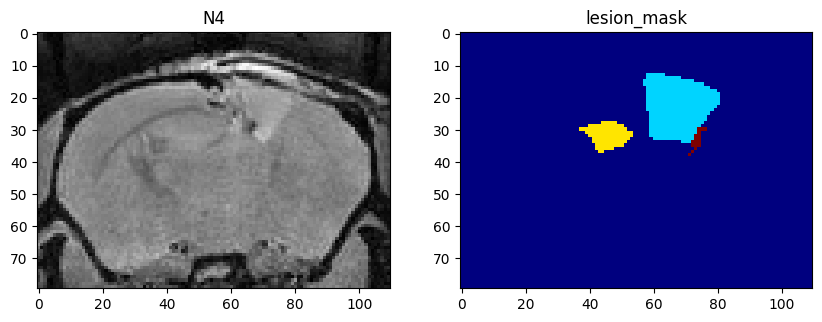

In [3]:
from utils.visualization import plot_data, plot_data_axis
from utils.loader import load_data

# Modalities
modalities = ['N4', 'lesion_mask']
layer=180
path = '../data_fix/fixed/'
for dir in os.listdir(path)[:2]:
    case = dir
    # Plot data
    images, data, file_paths = load_data(dir, path, modalities)
    print('unique: ', np.unique(data['lesion_mask']))
    print('max: ', np.max(data['lesion_mask']))


    plot_data_axis(data, layer, axis=2, rotation=-1) 

In [4]:
# resample each file in a folder to 1mm isotropic voxels with simpleitk
import SimpleITK as sitk
from utils.vedo import plot_two_volumes
import os

def resample_nifti(input_path, output_path, target_spacing=(.1,.1,.1)):
    # load nifti
    nib_img = nib.load(input_path)
    nii_img = sitk.ReadImage(input_path)
    # get spacing
    current_spacing = nii_img.GetSpacing()
    # calculate the resampling factor
    resample_factor = [current_dim / target_dim for current_dim, target_dim in zip(current_spacing, target_spacing)]
    # create a resampling transform
    resample_transform = sitk.ResampleImageFilter()
    resample_transform.SetOutputSpacing(target_spacing)
    resample_transform.SetSize([int(round(dim * factor)) for dim, factor in zip(nii_img.GetSize(), resample_factor)])

    resample_direction = nii_img.GetDirection()
    _direction = [[resample_direction[0], resample_direction[3], resample_direction[6]],[resample_direction[1], resample_direction[4], resample_direction[7]], [resample_direction[2], resample_direction[5], resample_direction[8]]]
    resample_transform.SetOutputDirection(_direction)
    resample_transform.SetOutputOrigin(nii_img.GetOrigin())
    # set same axis order as input
    # resample
    resampled = resample_transform.Execute(nii_img)
    # save
    # sitk.WriteImage(resampled, output_path)

    # extract nib image from sitk image
    resampled = sitk.GetArrayFromImage(resampled)

    resampled_nib_img = nib.Nifti1Image(resampled, nib_img.affine, nib_img.header, dtype=np.float64)
    # orient the resampled image to match the original
    #resampled_nib_img = nib.as_closest_canonical(resampled_nib_img)
    return resampled_nib_img

In [5]:
from scipy.ndimage import zoom

def res_nifti(input, target_resolution=(.1,.1,.1)):
    img = nib.load(input)
    affine = nib.affines.rescale_affine(img.affine, shape=img.shape, zooms=target_resolution)

    voxel_dims = img.header.get_zooms()
    # fix the voxel dimensions that were wrongly scaled by factors of 10
    detected_wrong_factor = np.round(voxel_dims[0] / target_resolution[0])
    if detected_wrong_factor > 1:
        voxel_dims = [dim / detected_wrong_factor for dim in voxel_dims]

    
    #print('VOXEL DIM - ', voxel_dims)

    #print('DIV', target_resolution[0], '/' , voxel_dims[0])
    scale_factors =  [current_dim / target_dim for current_dim, target_dim in zip(voxel_dims, target_resolution)]
    #print('COMPUTED SCALE FACTORS - ', scale_factors)

    # if input is the lesion mask then use nearest neighbor interpolation
    if 'lesion_mask' in input:
        resampled_data = zoom(img.get_fdata(), scale_factors, order=0, mode='nearest')
    else:
        resampled_data = zoom(img.get_fdata(), scale_factors, order=3)

    return nib.Nifti1Image(resampled_data, affine, img.header, dtype=np.float64)


unique:  [0. 1. 2. 3.]
max:  3.0
(150, 150, 37)
(150, 150, 111)
(110, 80, 300)
(110, 80, 300)


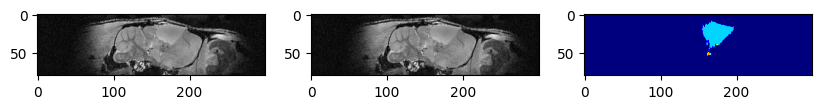

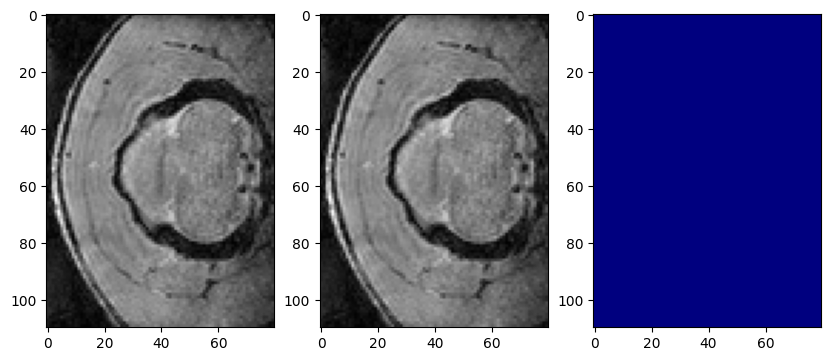

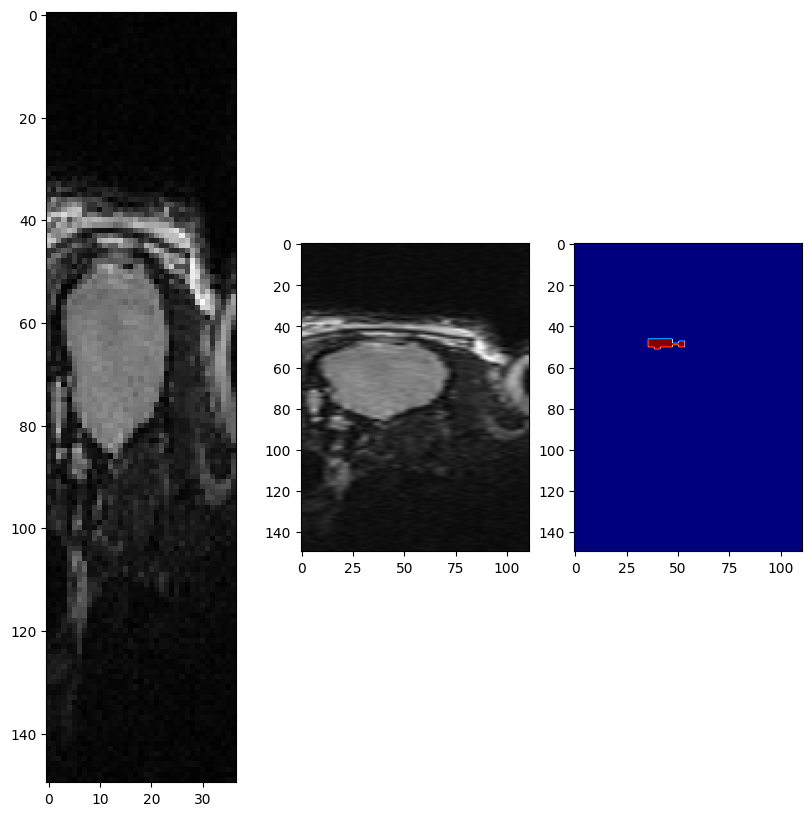

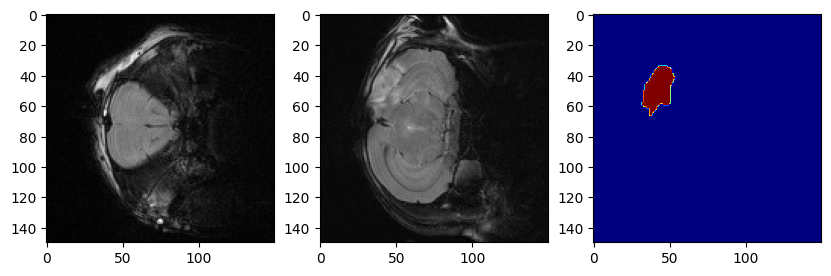

In [20]:
path = '../dataset/'
case = 'TBI_fm_19_53'

# load nifti
nii_img, nii_data = load_nifti(os.path.join(path, case, 'Anat', case + '_N4.nii.gz'))
resampled_nii_img = res_nifti(os.path.join(path, case, 'Anat', case + '_N4.nii.gz'))
mask_img, mask_data = load_nifti(os.path.join(path, case, 'Anat', case + '_lesion_mask.nii.gz'))
resampled_mask_img = res_nifti(os.path.join(path, case, 'Anat', case + '_lesion_mask.nii.gz'))
# print unique values in mask
print('unique: ', np.unique(resampled_mask_img.get_fdata()))
print('max: ', np.max(resampled_mask_img.get_fdata()))

path = '../data_fix/downsampled/'
case = 'TBI_PTE_fm_20_175'
nii_img2, nii_data2 = load_nifti(os.path.join(path, case, 'Anat', case + '_N4.nii.gz'))
resampled_nii_img2 = res_nifti(os.path.join(path, case, 'Anat', case + '_N4.nii.gz'))
mask_img2, mask_data2 = load_nifti(os.path.join(path, case, 'Anat', case + '_lesion_mask.nii.gz'))
resampled_mask_img2 = res_nifti(os.path.join(path, case, 'Anat', case + '_lesion_mask.nii.gz'))


# plot with plt 
print(nii_img.shape)
print(resampled_nii_img.shape)
print(nii_img2.shape)
print(resampled_nii_img2.shape)

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(nii_img2.get_fdata()[30,:,:], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(resampled_nii_img2.get_fdata()[30,:,:], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(resampled_mask_img2.get_fdata()[30,:,:], cmap='jet')
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(nii_img2.get_fdata()[:,:,100], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(resampled_nii_img2.get_fdata()[:,:,100], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(resampled_mask_img2.get_fdata()[:,:,100], cmap='jet')
plt.show()


plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(nii_img.get_fdata()[30,:,:], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(resampled_nii_img.get_fdata()[30,:,:], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(resampled_mask_img.get_fdata()[30,:,:], cmap='jet')
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(nii_img.get_fdata()[:,:,30], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(resampled_nii_img.get_fdata()[:,:,30], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(resampled_mask_img.get_fdata()[:,:,30], cmap='jet')
plt.show()

plot_two_volumes(resampled_nii_img.get_fdata(), resampled_nii_img2.get_fdata())
plot_two_volumes(resampled_mask_img.get_fdata(), resampled_mask_img2.get_fdata())

In [18]:
# resample each file in a folder to 1mm isotropic voxels with simpleitk
path = '../data_fix/downsampled/'
for case in os.listdir(path):
    # resample nifti
    modalities = ['N4', 'lesion_mask']
    for modality in modalities:
        input_path = os.path.join(path, case, 'Anat', case + '_' + modality + '.nii.gz')
        nib_img = nib.load(input_path)
        resampled = res_nifti(input_path)
        nib.save(resampled, input_path)

case:  TBI_PTE_fm_20_175
case:  TBI_PTE_fm_20_177
case:  TBI_PTE_fm_20_178
case:  TBI_PTE_fm_20_179
case:  TBI_PTE_fm_20_17_3w
case:  TBI_PTE_fm_20_17_5m
case:  TBI_PTE_fm_20_182
case:  TBI_PTE_fm_20_183
case:  TBI_PTE_fm_20_184
case:  TBI_PTE_fm_20_18_3w
case:  TBI_PTE_fm_20_18_5m
case:  TBI_PTE_fm_20_192
case:  TBI_PTE_fm_20_193
case:  TBI_PTE_fm_20_195
case:  TBI_PTE_fm_20_196
case:  TBI_PTE_fm_20_197
case:  TBI_PTE_fm_20_20_3w
case:  TBI_PTE_fm_20_20_5m
case:  TBI_PTE_fm_20_21_3w
case:  TBI_PTE_fm_20_21_5m


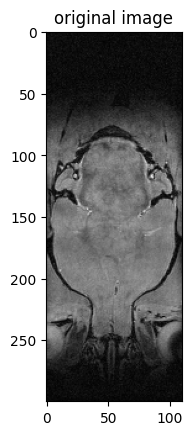

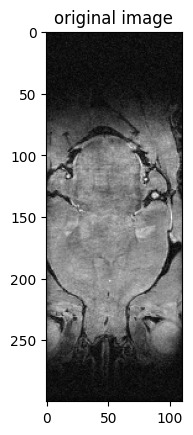

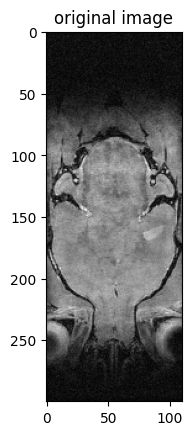

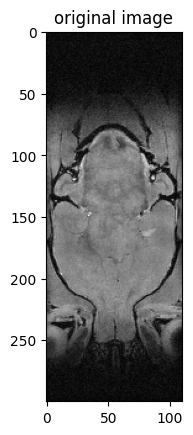

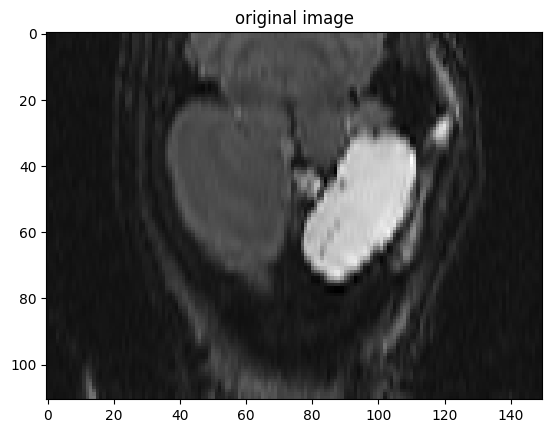

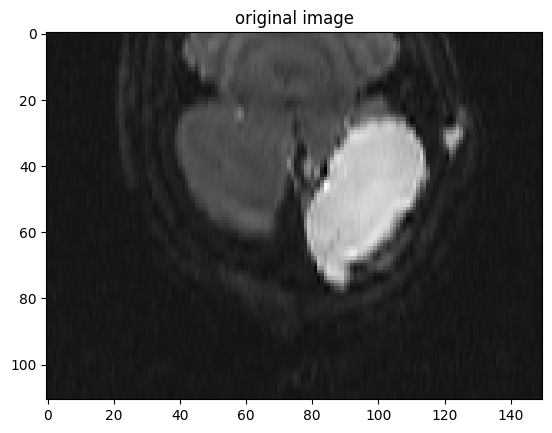

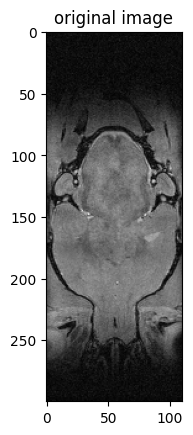

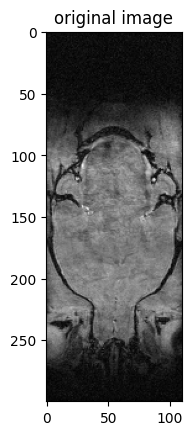

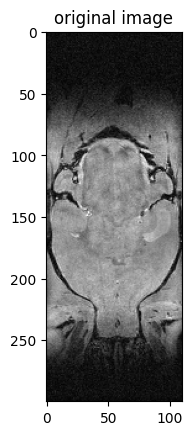

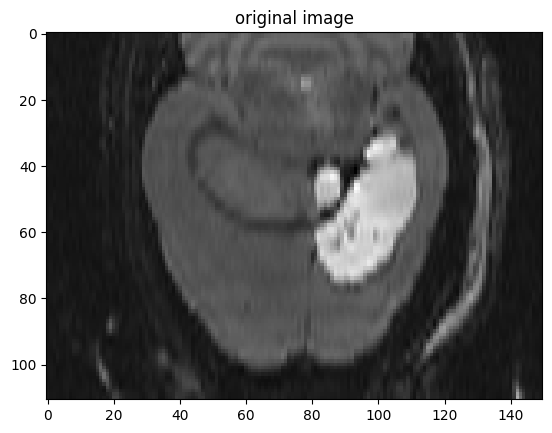

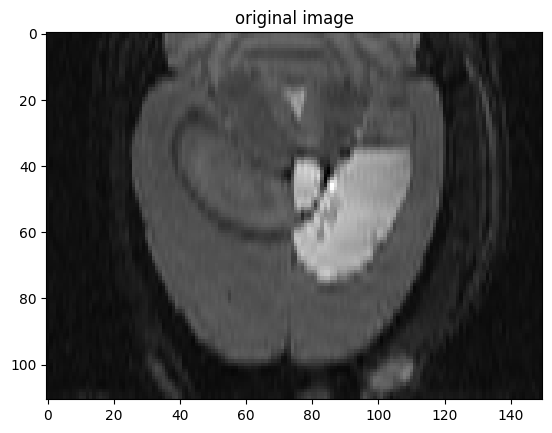

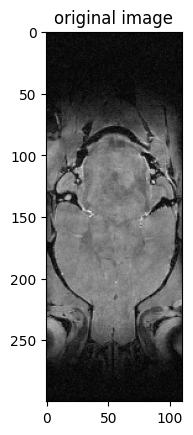

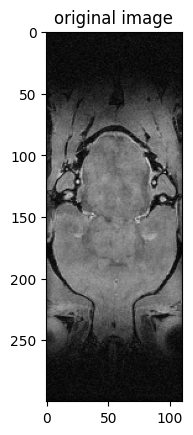

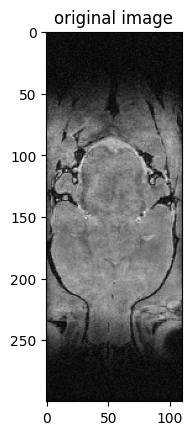

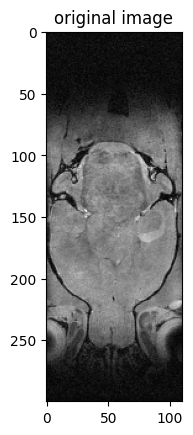

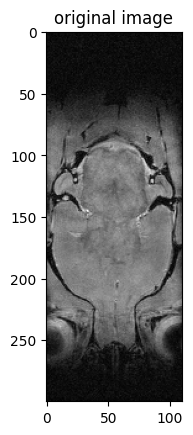

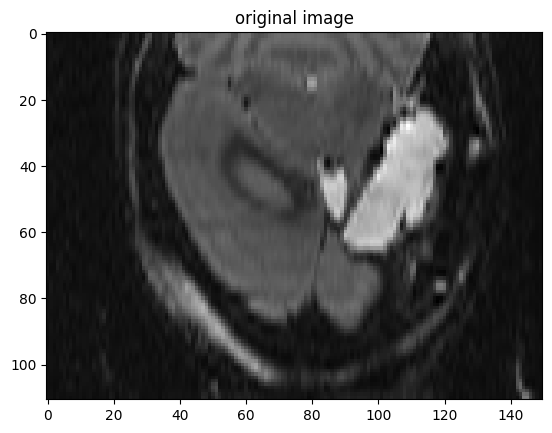

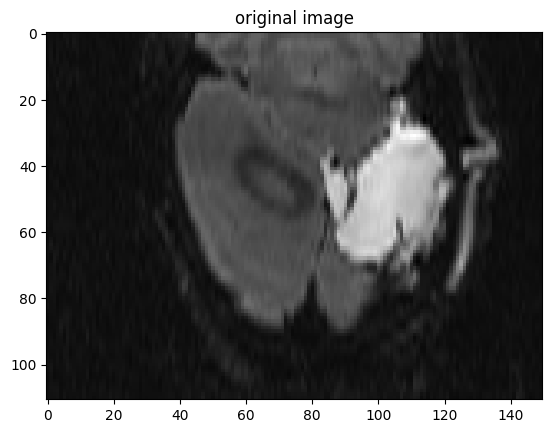

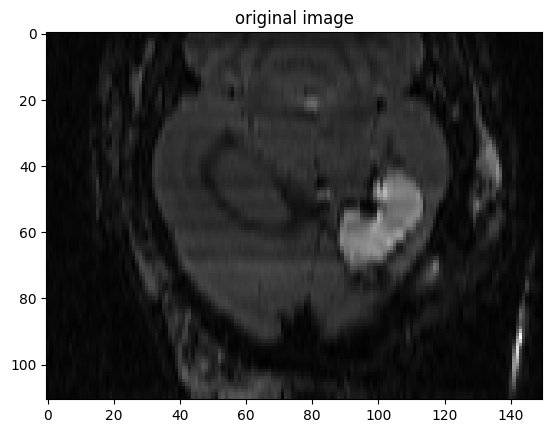

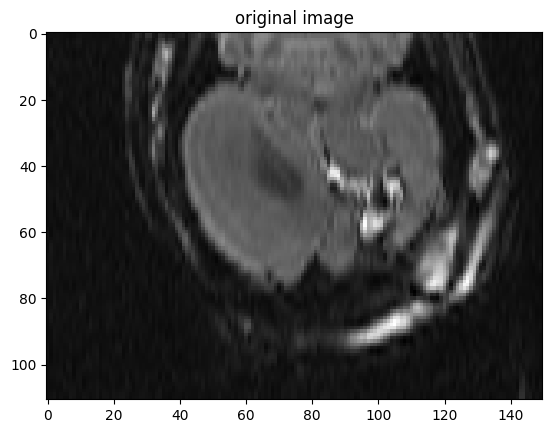

In [19]:
path = '../data_fix/downsampled/'
for case in os.listdir(path)[-20:]:
    # plot resampled nifti
    modalities = ['N4']
    for modality in modalities:
        input_path = os.path.join(path, case, 'Anat', case + '_' + modality + '.nii.gz')
        nib_img = nib.load(input_path)
        print('case: ', case)
        plt.figure()
        # plot the original image, the original mask, the resampled image and the resampled mask with a title
        plt.imshow(np.rot90(nib_img.get_fdata()[:,50,:], k=-1), cmap='gray')
        plt.title('original image')

TBI_PTE_fm_20_175


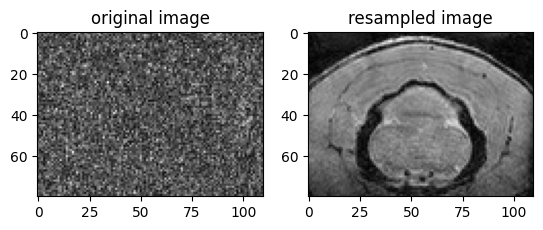

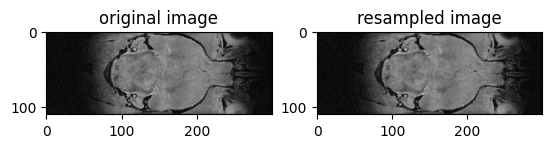

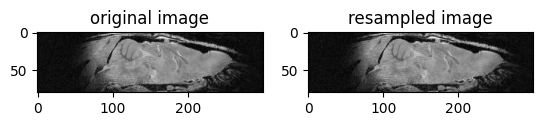

TBI_PTE_fm_20_177


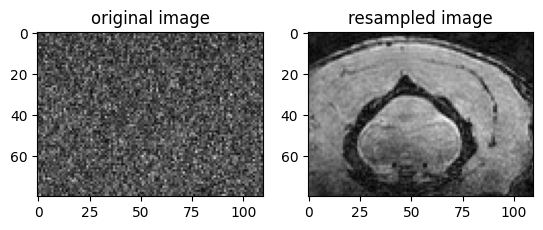

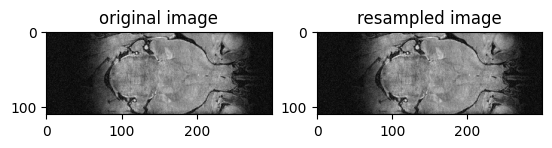

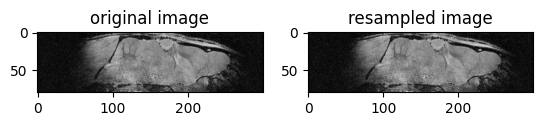

TBI_PTE_fm_20_178


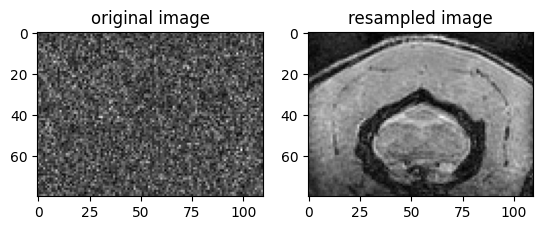

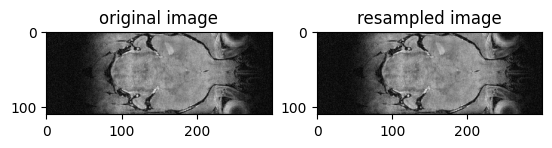

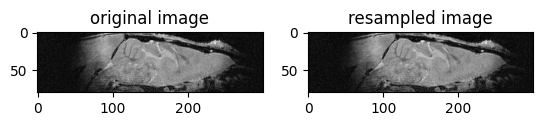

TBI_PTE_fm_20_179


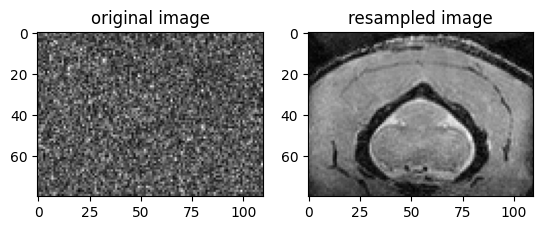

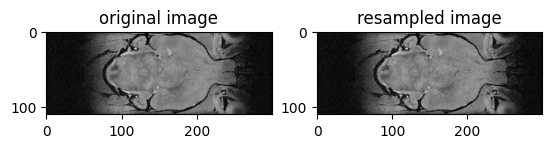

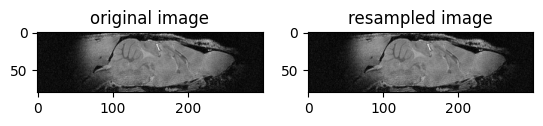

TBI_PTE_fm_20_17_3w


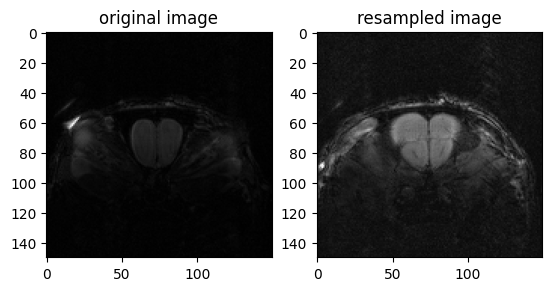

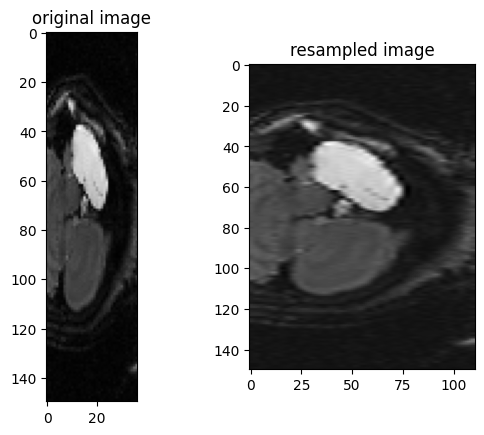

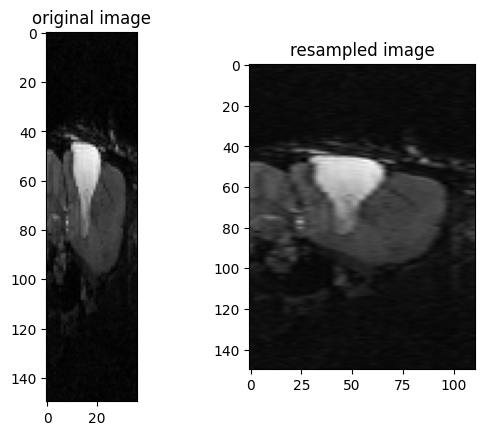

TBI_PTE_fm_20_17_5m


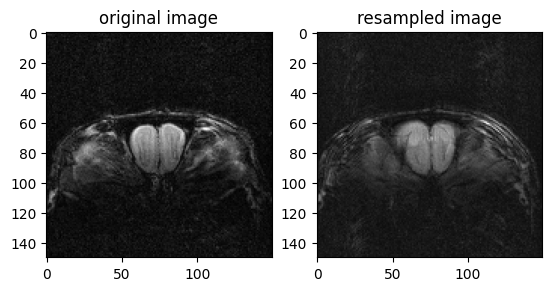

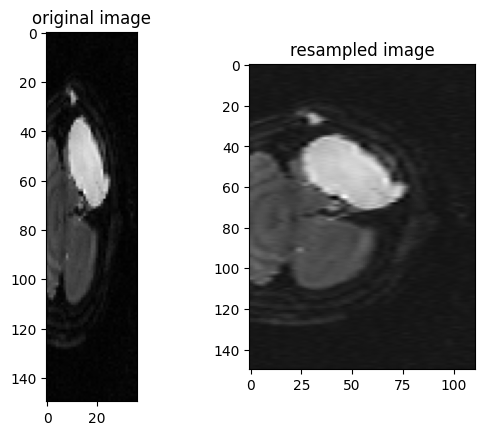

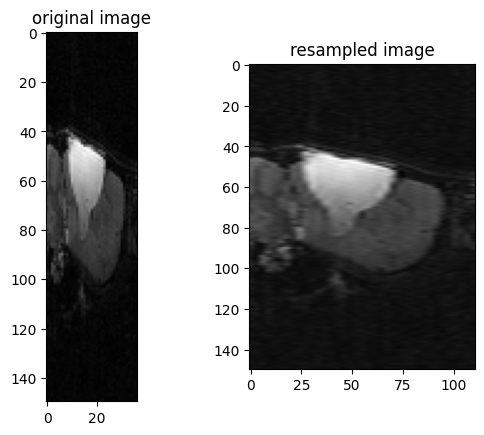

TBI_PTE_fm_20_182


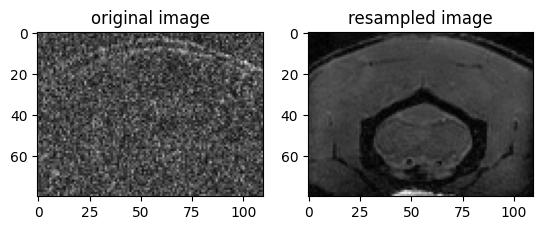

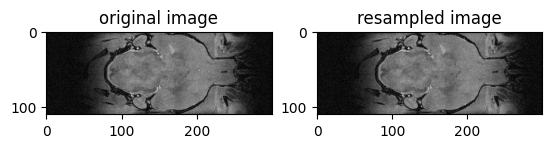

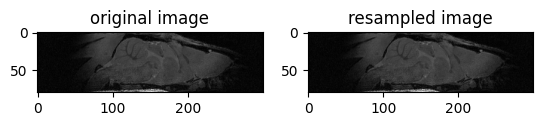

TBI_PTE_fm_20_183


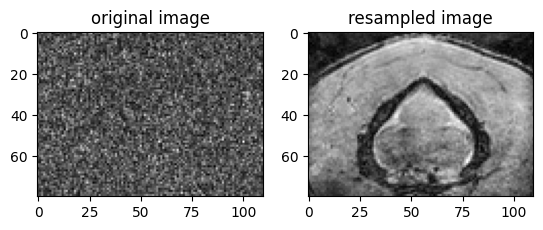

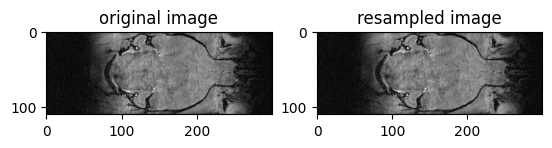

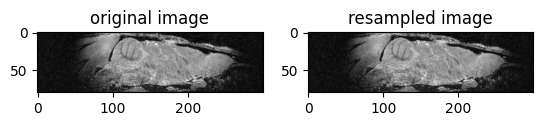

TBI_PTE_fm_20_184


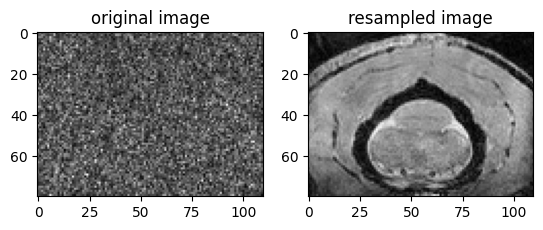

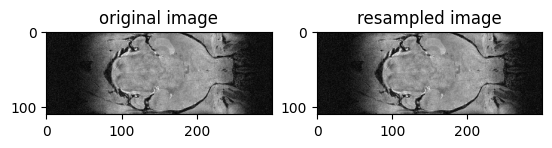

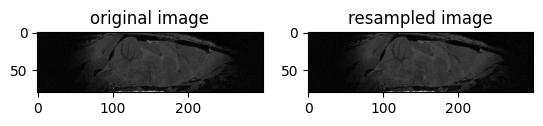

TBI_PTE_fm_20_18_3w


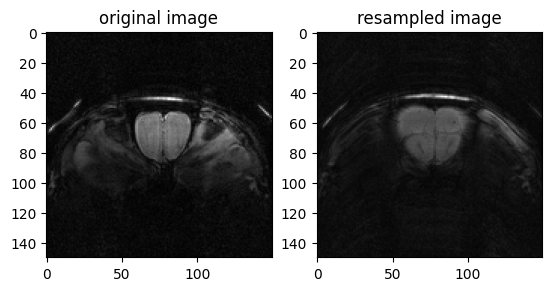

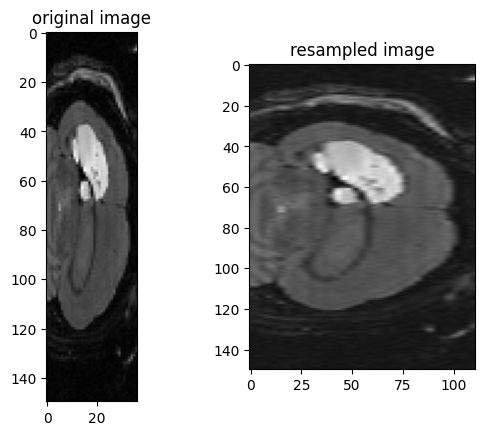

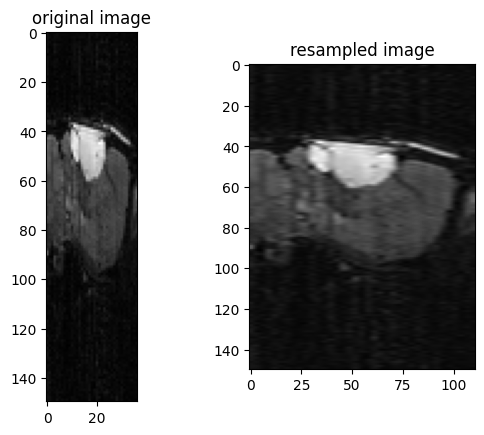

TBI_PTE_fm_20_18_5m


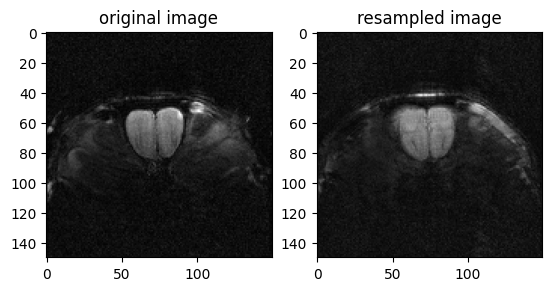

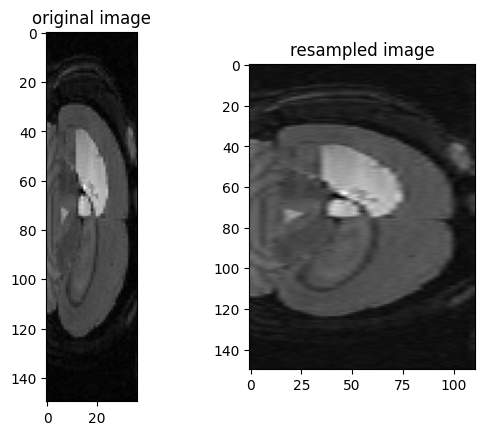

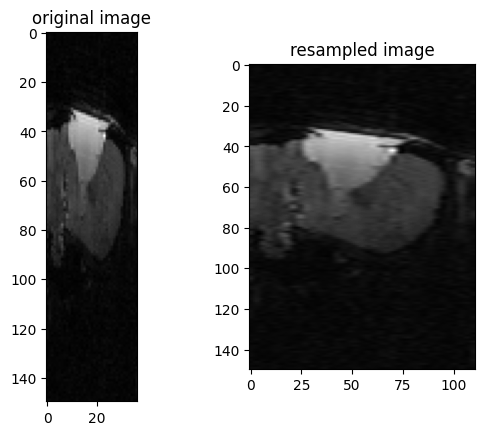

TBI_PTE_fm_20_192


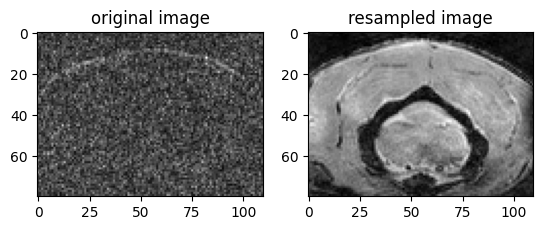

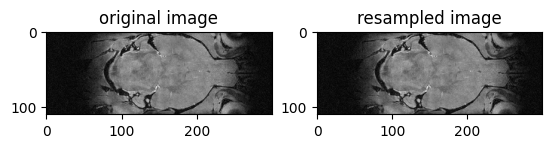

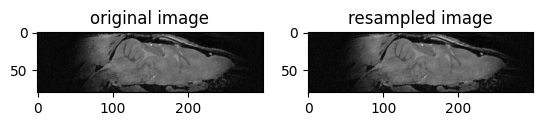

TBI_PTE_fm_20_193


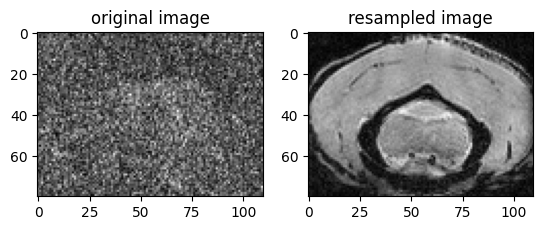

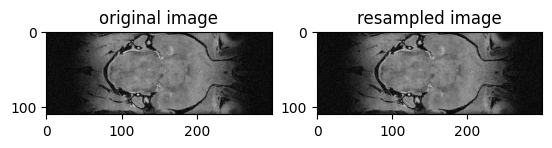

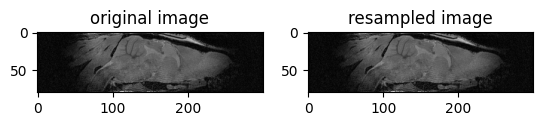

TBI_PTE_fm_20_195


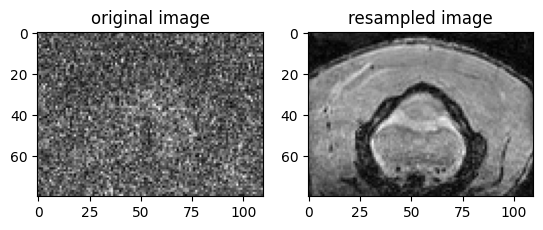

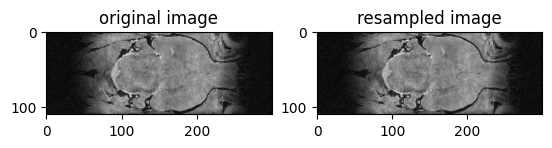

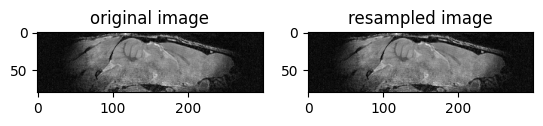

TBI_PTE_fm_20_196


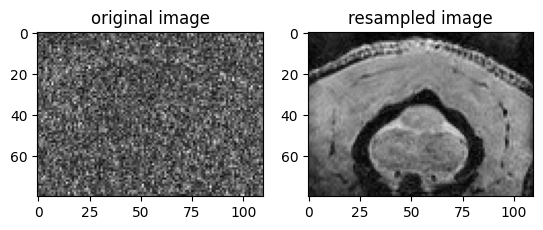

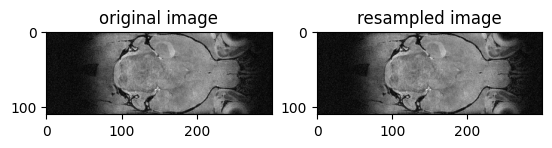

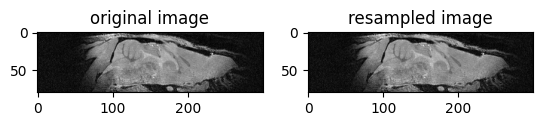

TBI_PTE_fm_20_197


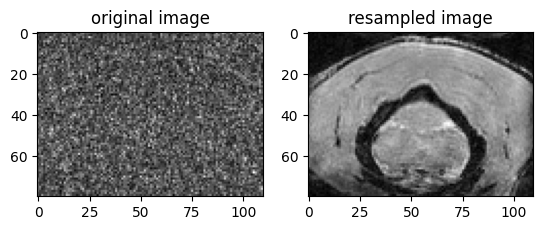

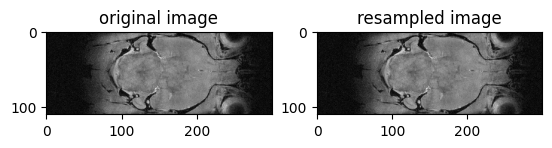

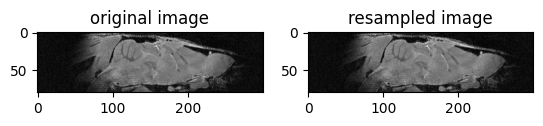

TBI_PTE_fm_20_20_3w


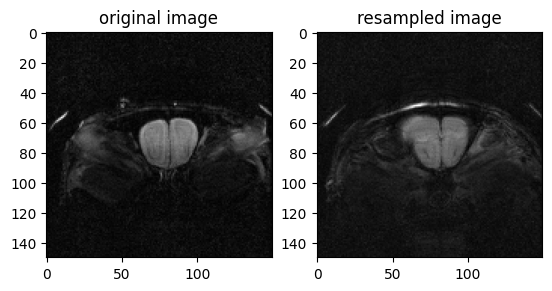

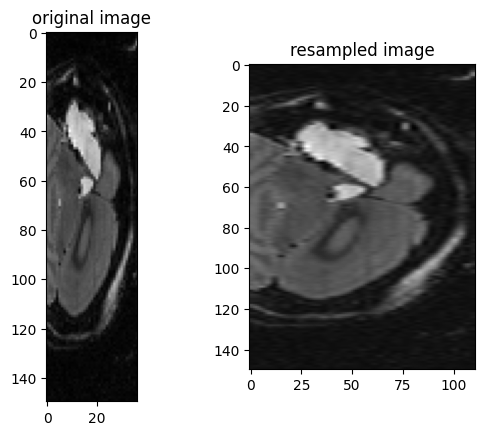

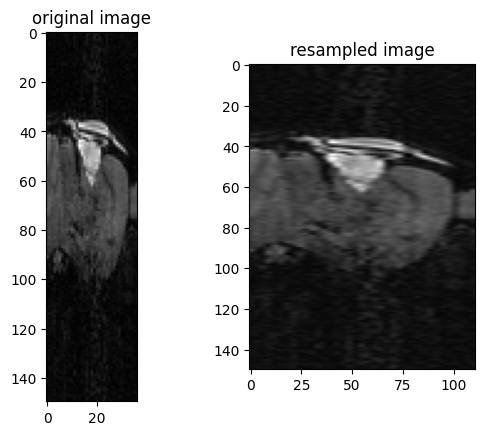

TBI_PTE_fm_20_20_5m


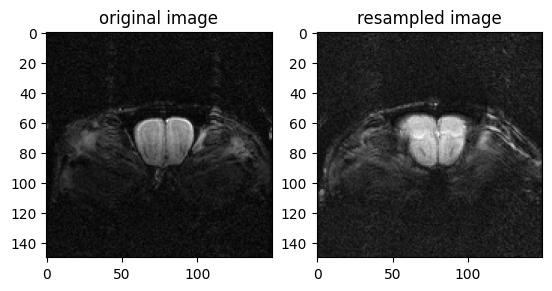

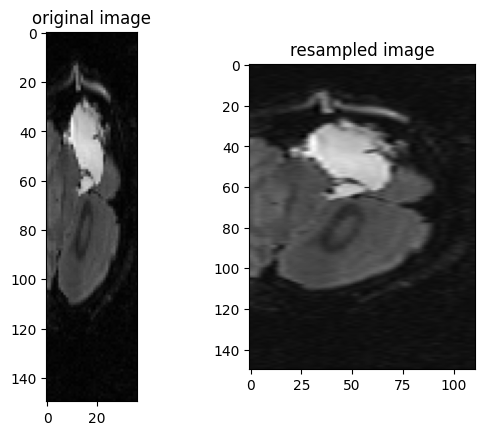

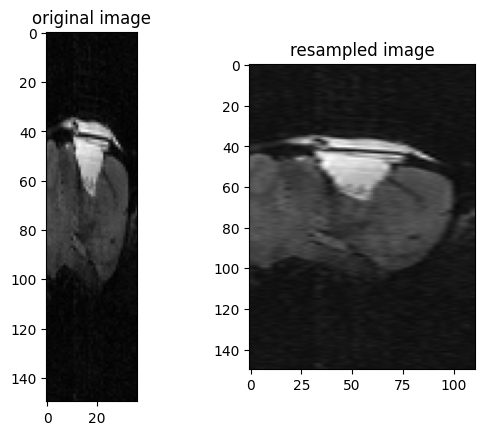

TBI_PTE_fm_20_21_3w


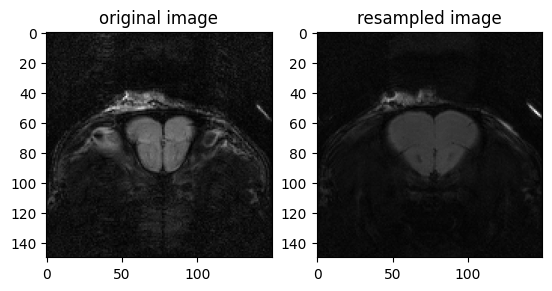

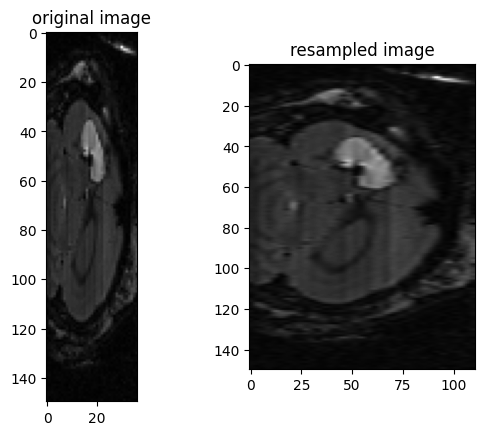

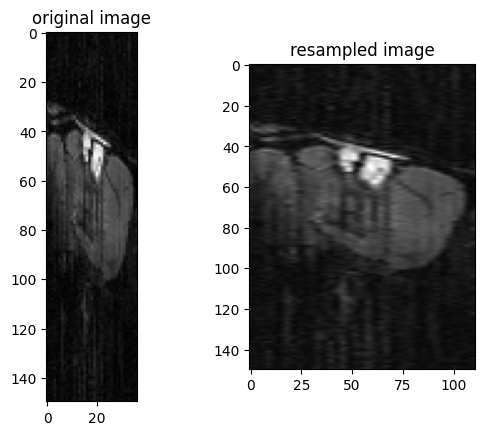

TBI_PTE_fm_20_21_5m


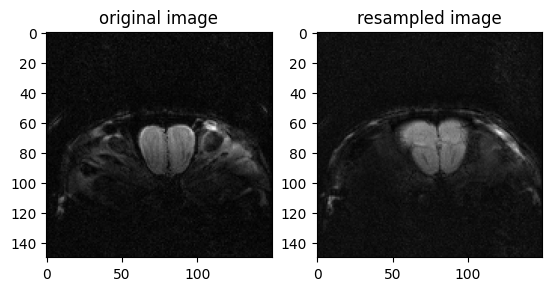

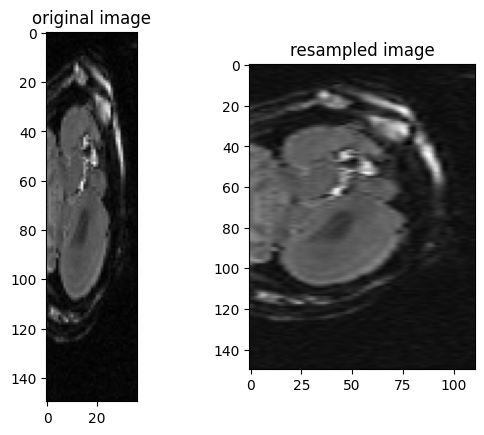

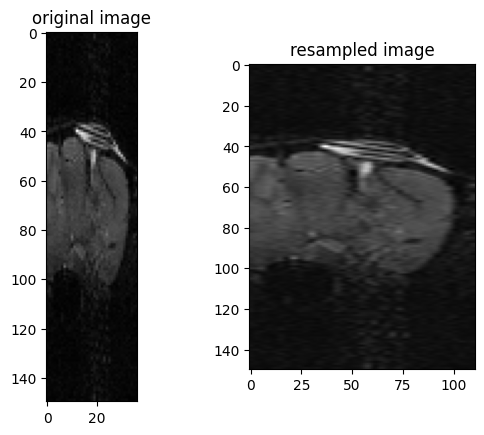

In [9]:
'''

# RESAMPLE WHOLE DATASET

# resample each file in a folder to 1mm isotropic voxels with simpleitk
path = '../dataset/'
path = '../data_fix/cropped/'
for case in os.listdir(path)[-20:]:
    # resample nifti
    modalities = ['N4', 'lesion_mask']
    print(case)
    for modality in modalities:
        input_path = os.path.join(path, case, 'Anat', case + '_' + modality + '.nii.gz')
        nib_img = nib.load(input_path)
        output_path = os.path.join(path, case, 'Anat', case + '_' + modality + '_resampled.nii.gz')
        resampled = res_nifti(input_path)
        # print shape
        # print('shape: ', resampled.get_fdata().shape)
        # plot resampled
        plt.figure()
        # plot the original image, the original mask, the resampled image and the resampled mask with a title
        plt.subplot(1,2,1)
        plt.imshow(np.rot90(nib_img.get_fdata()[:,:,35], k=-1), cmap='gray')
        plt.title('original image')
        plt.subplot(1,2,2)
        plt.imshow(np.rot90(resampled.get_fdata()[:,:,100], k=-1), cmap='gray')
        plt.title('resampled image')
        plt.show()
        plt.subplot(1,2,1)
        plt.imshow(nib_img.get_fdata()[:,50,:], cmap='gray')
        plt.title('original image')
        plt.subplot(1,2,2)
        plt.imshow(resampled.get_fdata()[:,50,:], cmap='gray')
        plt.title('resampled image')
        plt.show()
        # increase the size of the subplot
        plt.subplot(1,2,1)
        plt.imshow(nib_img.get_fdata()[50,:,:], cmap='gray')
        plt.title('original image')
        plt.subplot(1,2,2)
        plt.imshow(resampled.get_fdata()[50,:,:], cmap='gray')
        plt.title('resampled image')
        plt.show()


'''

        